## Toronto Crime Analysis

### This notebook uses crime data (from Toronto Police API) and income data (from Canada Census API) to explore correlations between income and crime in Toronto neighborhoods

In [1]:
%matplotlib notebook

In [25]:
import requests
import json
import pandas as pd
from matplotlib import pyplot as plt
from pprint import pprint
from pandas.io.json import json_normalize
from IPython.display import clear_output
from scipy import stats

In [3]:
# read crime data
crimes_df = pd.DataFrame(pd.read_csv('../output/crimes_csv.csv', index_col=0))
crimes_df.head()

,Hood_ID,Index_,MCI,Neighbourhood,event_unique_id,occurrencedate,occurrenceday,occurrencedayofweek,occurrencedayofyear,occurrencehour,occurrencemonth,occurrenceyear,offence,premisetype
0,84,976,Assault,Little Portugal (84),GO-2015942420,1388552400000,1,Wednesday,1,0,January,2014,Assault,Apartment
1,25,977,Assault,Glenfield-Jane Heights (25),GO-20162295518,1388552400000,1,Wednesday,1,0,January,2014,Assault,Apartment
2,71,978,Assault,Cabbagetown-South St.James Town (71),GO-20142458487,1388552400000,1,Wednesday,1,0,January,2014,Assault,Apartment
3,71,979,Assault,Cabbagetown-South St.James Town (71),GO-20142458487,1388552400000,1,Wednesday,1,0,January,2014,Assault,Apartment
4,58,980,Theft Over,Old East York (58),GO-20141573896,1388552400000,1,Wednesday,1,0,January,2014,Theft Over,House


In [5]:
# read conversion data
toronto_tracts = pd.DataFrame(pd.read_csv('../output/hoods_to_tracts.csv'))

In [6]:
# get dguids
dguids = toronto_tracts['dguid'].reset_index(drop=True)
dguids

0      2016S05075350001.00
1      2016S05075350002.00
2      2016S05075350003.00
3      2016S05075350004.00
4      2016S05075350005.00
5      2016S05075350006.00
6      2016S05075350007.01
7      2016S05075350007.02
8      2016S05075350009.00
9      2016S05075350010.01
10     2016S05075350010.02
11     2016S05075350011.00
12     2016S05075350014.00
13     2016S05075350015.00
14     2016S05075350016.00
15     2016S05075350017.00
16     2016S05075350018.00
17     2016S05075350019.00
18     2016S05075350020.00
19     2016S05075350021.00
20     2016S05075350022.00
21     2016S05075350023.00
22     2016S05075350024.00
23     2016S05075350025.00
24     2016S05075350026.00
25     2016S05075350027.00
26     2016S05075350029.00
27     2016S05075350030.00
28     2016S05075350031.00
29     2016S05075350032.00
              ...         
464    2016S05075350376.12
465    2016S05075350376.13
466    2016S05075350376.14
467    2016S05075350377.01
468    2016S05075350377.02
469    2016S05075350377.03
4

#### Now we have a list of dguids that we can use in a for loop to fetch census data 
#### Income - topic 7

In [7]:
census_url = "https://www12.statcan.gc.ca/rest/census-recensement/CPR2016.json?lang=E&dguid="
income_topic = "&topic=7"

In [8]:
census_responses=[]
for i in range(len(dguids)):
    clear_output(wait=True)
    
    census_responses.append(requests.get(census_url + dguids[i] + income_topic))
    
    # response was taking long, found this way to track progress
    print( str( round((i/len(dguids))*100) ) + "% complete" )

100% complete


In [9]:
#explore data
pprint(census_responses[0].text)

('//{"COLUMNS":["PROV_TERR_ID","PROV_TERR_NAME_NOM","GEO_UID","GEO_ID","GEO_NAME_NOM","GEO_TYPE","TOPIC_THEME","TEXT_ID","HIER_ID","INDENT_ID","TEXT_NAME_NOM","NOTE_ID","NOTE","T_DATA_DONNEE","T_SYM","M_DATA_DONNEE","M_SYM","F_DATA_DONNEE","F_SYM"],"DATA":[["35","Ontario","2016S05075350001.00","5350001.00","0001.00",null,"Income",12000,"4.1.1",0,"Total '
 '- Income statistics in 2015 for the population aged 15 years and over in '
 'private households - 100% '
 'data",21,null,510.0,null,270.0,null,245.0,null],["35","Ontario","2016S05075350001.00","5350001.00","0001.00",null,"Income",12001,"4.1.1.1",1,"  '
 'Number of total income recipients aged 15 years and over in private '
 'households - 100% '
 'data",null,null,495.0,null,260.0,null,240.0,null],["35","Ontario","2016S05075350001.00","5350001.00","0001.00",null,"Income",12002,"4.1.1.1.1",2,"    '
 'Median total income in 2015 among recipients '
 '($)",null,null,41165.0,null,44672.0,null,36352.0,null],["35","Ontario","2016S05075350001.

In [10]:
test = json.loads(census_responses[0].text.replace("//",""))
pprint(test)

{'COLUMNS': ['PROV_TERR_ID',
             'PROV_TERR_NAME_NOM',
             'GEO_UID',
             'GEO_ID',
             'GEO_NAME_NOM',
             'GEO_TYPE',
             'TOPIC_THEME',
             'TEXT_ID',
             'HIER_ID',
             'INDENT_ID',
             'TEXT_NAME_NOM',
             'NOTE_ID',
             'NOTE',
             'T_DATA_DONNEE',
             'T_SYM',
             'M_DATA_DONNEE',
             'M_SYM',
             'F_DATA_DONNEE',
             'F_SYM'],
 'DATA': [['35',
           'Ontario',
           '2016S05075350001.00',
           '5350001.00',
           '0001.00',
           None,
           'Income',
           12000,
           '4.1.1',
           0,
           'Total - Income statistics in 2015 for the population aged 15 years '
           'and over in private households - 100% data',
           21,
           None,
           510.0,
           None,
           270.0,
           None,
           245.0,
           None],
          ['35'

           13014,
           '4.2.2.2.1.2',
           3,
           '      Average after-tax income of one-person households in 2015 '
           '($)',
           None,
           None,
           52254.0,
           None,
           None,
           '...',
           None,
           '...'],
          ['35',
           'Ontario',
           '2016S05075350001.00',
           '5350001.00',
           '0001.00',
           None,
           'Income',
           13015,
           '4.2.2.2.2',
           2,
           '    Total - Income statistics in 2015 for two-or-more-person '
           'private households - 25% sample data',
           None,
           None,
           175.0,
           None,
           None,
           '...',
           None,
           '...'],
          ['35',
           'Ontario',
           '2016S05075350001.00',
           '5350001.00',
           '0001.00',
           None,
           'Income',
           13016,
           '4.2.2.2.2.1',
           3,
        

           'Ontario',
           '2016S05075350001.00',
           '5350001.00',
           '0001.00',
           None,
           'Income',
           15004,
           '4.4.1.3',
           1,
           '  65 years and over',
           None,
           None,
           50.0,
           None,
           20.0,
           None,
           30.0,
           None],
          ['35',
           'Ontario',
           '2016S05075350001.00',
           '5350001.00',
           '0001.00',
           None,
           'Income',
           15005,
           '4.4.2',
           0,
           'In low income based on the Low-income measure, after tax (LIM-AT)',
           None,
           None,
           80.0,
           None,
           40.0,
           None,
           35.0,
           None],
          ['35',
           'Ontario',
           '2016S05075350001.00',
           '5350001.00',
           '0001.00',
           None,
           'Income',
           15006,
           '4.4.2.1',
         

In [12]:
# explore metrics:
for i in range(len(test['DATA'])):
    print(test['DATA'][i][10])

Total - Income statistics in 2015 for the population aged 15 years and over in private households - 100% data
  Number of total income recipients aged 15 years and over in private households - 100% data
    Median total income in 2015 among recipients ($)
  Number of after-tax income recipients aged 15 years and over in private households - 100% data
    Median after-tax income in 2015 among recipients ($)
  Number of market income recipients aged 15 years and over in private households - 100% data
    Median market income in 2015 among recipients ($)
  Number of government transfers recipients aged 15 years and over in private households - 100% data
    Median government transfers in 2015 among recipients ($)
  Number of employment income recipients aged 15 years and over in private households - 100% data
    Median employment income in 2015 among recipients ($)
Total - Income statistics in 2015 for the population aged 15 years and over in private households - 25% sample data
  Number

In [13]:
# pick a good metric: Average total income
test['DATA'][13][13]

56952.0

In [14]:
# get tracts and average income
tract=[]
average_incomes = []
for i in range(len(census_responses)):
    tract.append(json.loads(census_responses[i].text.replace("//",""))['DATA'][13][3])
    average_incomes.append(json.loads(census_responses[i].text.replace("//",""))['DATA'][13][13])

In [15]:
incomes_df_raw = pd.DataFrame({
    "census_tract" : tract ,
    "average_income" : average_incomes
})

In [16]:
toronto_tracts['census_tract'] = toronto_tracts['census_tract'].map("{0:.2f}".format)

In [17]:
incomes_df = pd.merge(toronto_tracts,incomes_df_raw, on='census_tract')
incomes_df.head()

,census_tract,hood_id,neighbourhood,dguid,average_income
0,5350001.00,70,South Riverdale,2016S05075350001.00,56952.0
1,5350002.00,77,Waterfront Communities-The Island,2016S05075350002.00,56461.0
2,5350003.00,85,South Parkdale,2016S05075350003.00,57547.0
3,5350004.00,85,South Parkdale,2016S05075350004.00,31133.0
4,5350005.00,85,South Parkdale,2016S05075350005.00,39903.0


In [18]:
incomes_by_neighborhood = incomes_df.groupby('hood_id').mean()
incomes_by_neighborhood.head()

,average_income
hood_id,
1,31138.833333
2,26815.000000
3,32880.500000
4,34970.500000
5,31303.500000


In [19]:
crimes_df = crimes_df.rename(columns={"Hood_ID":"hood_id"})

In [20]:
# types of indicators
MCIs = list(crimes_df.groupby('MCI').groups)
MCIs

['Assault', 'Auto Theft', 'Break and Enter', 'Robbery', 'Theft Over']

In [21]:
crimes_counts = crimes_df.groupby(['hood_id', 'MCI'])['event_unique_id'].count()
crimes_counts_df = crimes_counts.to_frame().unstack('MCI')

In [74]:
#crimes_totals = crimes_df.groupby(['hood_id'])['event_unique_id'].count()
#crimes_totals.to_csv('../output/crime_totals_per_hood.csv')

In [22]:
crimes_counts_df.head()

event_unique_id                                              
MCI             Assault Auto Theft Break and Enter Robbery Theft Over
hood_id                                                              
1                  1082       1181             503     306        192
2                  1048        217             140     387         14
3                   225         62              86      92         10
4                   285         83              62      75          4
5                   246         59              56      78          5

In [67]:
crimes_with_income = pd.merge(crimes_counts_df,incomes_by_neighborhood, on='hood_id')
crimes_with_income.columns = ['Assault','Auto Theft','Break and Enter','Robbery','Theft Over','Average Income']
crimes_with_income.head()

/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,Assault,Auto Theft,Break and Enter,Robbery,Theft Over,Average Income
hood_id,,,,,,
1,1082,1181,503,306,192,31138.833333
2,1048,217,140,387,14,26815.000000
3,225,62,86,92,10,32880.500000
4,285,83,62,75,4,34970.500000
5,246,59,56,78,5,31303.500000


In [69]:
# export
crimes_with_income.to_csv('../output/crimes_with_income.csv')

<IPython.core.display.Javascript object>


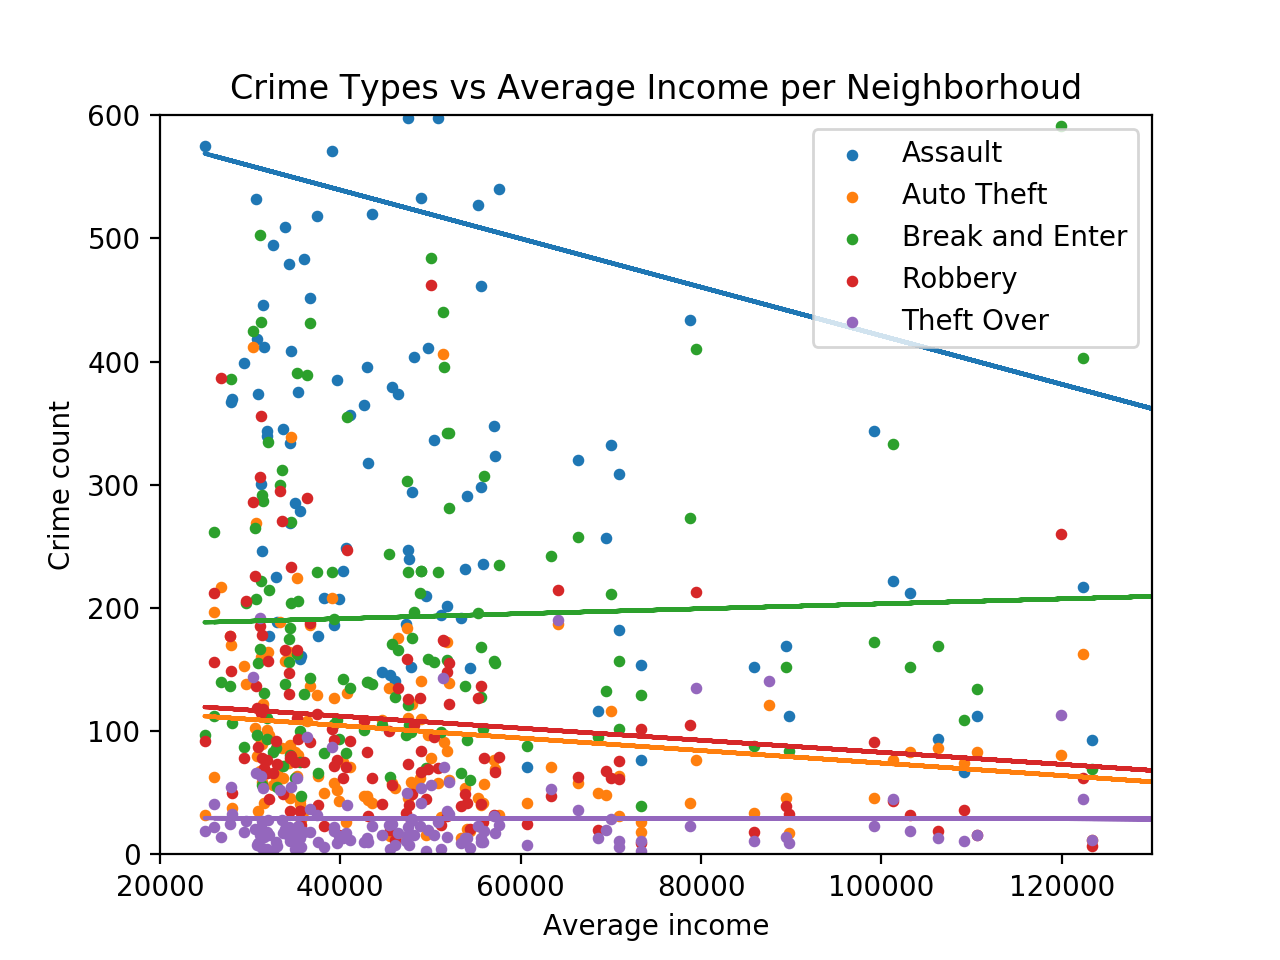

In [64]:
for MCI in MCIs:
    plt.scatter(crimes_with_income['Average Income'],crimes_with_income[MCI], s=10)                
plt.legend()
plt.xlim(20000,130000)
plt.ylim(0,600)
plt.title('Crime Types vs Average Income per Neighborhoud')
plt.xlabel('Average income')
plt.ylabel('Crime count')
plt.show()

In [37]:
# looks like assault has the biggest correlation, but trends are generally not that clear, lets try linear regression

In [65]:
x = crimes_with_income['Average Income']
for MCI in MCIs:
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, crimes_with_income[MCI])
    plt.plot(x,intercept + slope*x)     
plt.savefig('../output/crimes-vs-income')

### Trends:
### -Assault rates decrease consdiderabely in neighborhoods with higher average incomes
### - Break and enter occurances are a little higher in neighborhoods with higher incomes - maybe due to nicer houses?
### - Auto theft, robbery, and theftover are not significantly different in neighborhoods with higher or lower average incomes